In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from utils import *
from numpy.fft import fft2, ifft2, fftshift
from SALSA import SALSA

In [2]:
img_ref = cv2.cvtColor( cv2.imread("images/cameraman.tif"), cv2.COLOR_BGR2GRAY)
M, N = img_ref.shape[:2]

In [3]:
h_blur = make_blur_kernel(51, M, blur_type=1)

HF = fft2(h_blur)

def A_op(x):
    YF = np.multiply(HF,fft2(x))
    y = np.real( ifft2(YF) )
    return y

def AT_op(x):
    YF = np.multiply(HF.conjugate(),fft2(x))
    y = np.real( ifft2(YF) )
    return y

In [4]:
SNRdb = 20
y = A_op( addGaussianNoise(img_ref, SNRdb) )

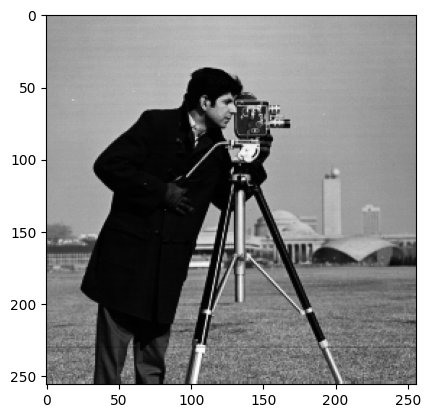

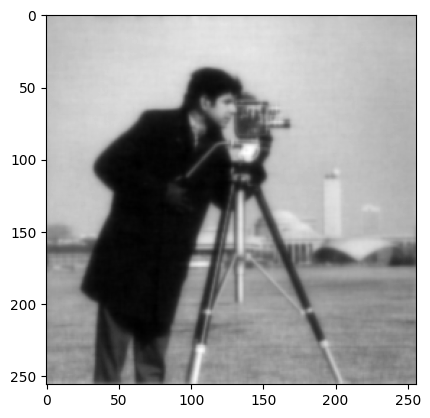

In [5]:
plt.figure(1)
plt.imshow(img_ref, cmap=plt.cm.gray)

plt.figure(2)
plt.imshow(y, cmap=plt.cm.gray)

In [6]:
lambda_reg = 0.025
mu = lambda_reg*10
outeriters = 500
tol = 1e-4
chambolleit = 5

def Phi(x):
    return TVnorm(x)

def Psi(x,th):
    return denoiseTV(x,th,chambolleit,1e-2,np.array([0]),np.array([0]))

filter_FFT = np.divide( np.ones(y.shape), (np.abs(HF)**2 + mu) )

def invLS(x, mu):
    filter_FFT = np.divide( np.ones(y.shape), (np.abs(HF)**2 + mu) )
    return np.real( ifft2( np.multiply( filter_FFT,fft2(x) ) ) )

In [7]:
salsa_obj = SALSA( y, A=A_op, AT=AT_op, invLS=invLS, tau=1, isTVinitialization=1)

x, objective, times, distance, numA, numAt, mses = salsa_obj.predict(y, tau=lambda_reg,mu = 5e-3,\
                                                                     stopCriterion=1,\
                                                                     x_true=img_ref,\
                                                                     x_init=2,\
                                                                     MaxIt=outeriters,\
                                                                     tolA=1e-4,\
                                                                     verbose=1)

print ("ISNR is ",myISNR(img_ref,y,x))

Initial value of objective function = 3.64e+06
iter= 0, obj= 7.49e+03, stop criterion= 1.00e+00, (target= 1.00e-04), MSE = 50.16
iter= 1, obj= 3.07e+04, stop criterion= 3.10e+00, (target= 1.00e-04), MSE = 35.55
iter= 2, obj= 2.20e+04, stop criterion= 2.84e-01, (target= 1.00e-04), MSE = 31.86
iter= 3, obj= 2.16e+04, stop criterion= 1.76e-02, (target= 1.00e-04), MSE = 30.60
iter= 4, obj= 2.17e+04, stop criterion= 5.19e-03, (target= 1.00e-04), MSE = 30.14
iter= 5, obj= 2.18e+04, stop criterion= 4.52e-03, (target= 1.00e-04), MSE = 29.97
iter= 6, obj= 2.18e+04, stop criterion= 2.69e-03, (target= 1.00e-04), MSE = 29.91
iter= 7, obj= 2.19e+04, stop criterion= 1.52e-03, (target= 1.00e-04), MSE = 29.91
iter= 8, obj= 2.19e+04, stop criterion= 8.77e-04, (target= 1.00e-04), MSE = 29.92
iter= 9, obj= 2.19e+04, stop criterion= 5.26e-04, (target= 1.00e-04), MSE = 29.94
iter= 10, obj= 2.19e+04, stop criterion= 3.29e-04, (target= 1.00e-04), MSE = 29.97
iter= 11, obj= 2.19e+04, stop criterion= 2.15e-04,

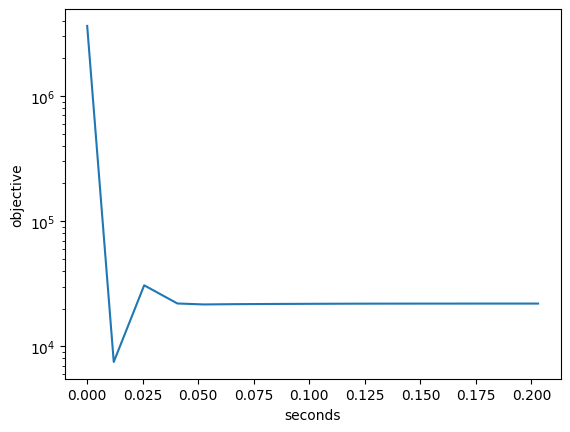

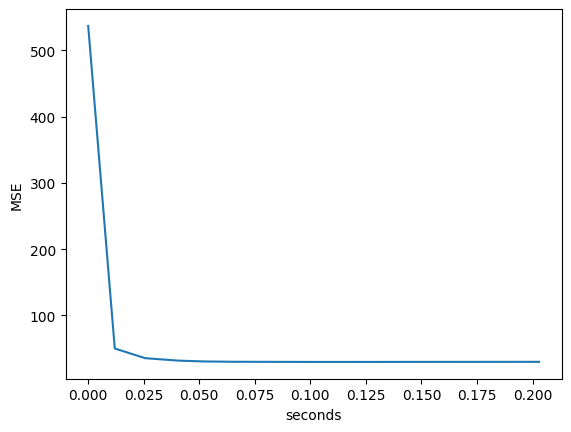

In [11]:
plt.semilogy(times,objective)
plt.xlabel('seconds')
plt.ylabel('objective')
plt.show()

plt.plot(times,mses)
plt.xlabel('seconds')
plt.ylabel('MSE')
plt.show()

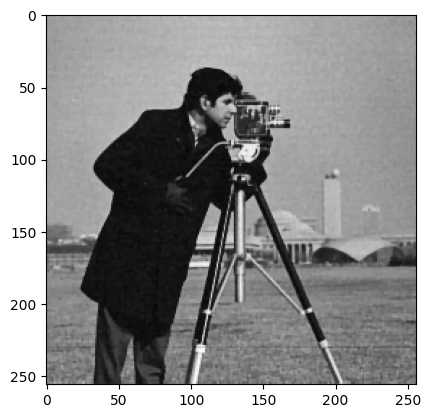

In [9]:
# visualizar a estimativa
plt.imshow(x, cmap=plt.cm.gray)
plt.show()